In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_platform_name", "cpu")
from jax.nn import relu
import numpy as np

# ReLU MLPs

In [2]:
def generate_all_genomes(n: int) -> jax.Array:
    assert n <= 8, "n must be less than or equal to 8"
    numbers = np.arange(0, 2**n).astype(np.uint8)
    bits = np.unpackbits(numbers[:, np.newaxis], axis=1)
    combinations = bits[:, -n:]
    return jnp.asarray(combinations)

def forward_fn(x, w1, b1, w2, b2, W3, b3, genome):
    """relu(relu(x @ W1 + b1) @ W2 + genome*b2) @ (genome[:, None]*W3) + b3"""
    # shift x from [0, 1] to [-1, 1]
    x = x / 1 - 1
    x = jnp.dot(x, w1) + b1  # (B, num_features)
    x = relu(x)
    x = jnp.dot(x, w2) + genome*b2  # (B, genome_length)
    x = relu(x)
    x = jnp.dot(x, genome[:, None]*W3) + b3  # (B, 1)
    return x

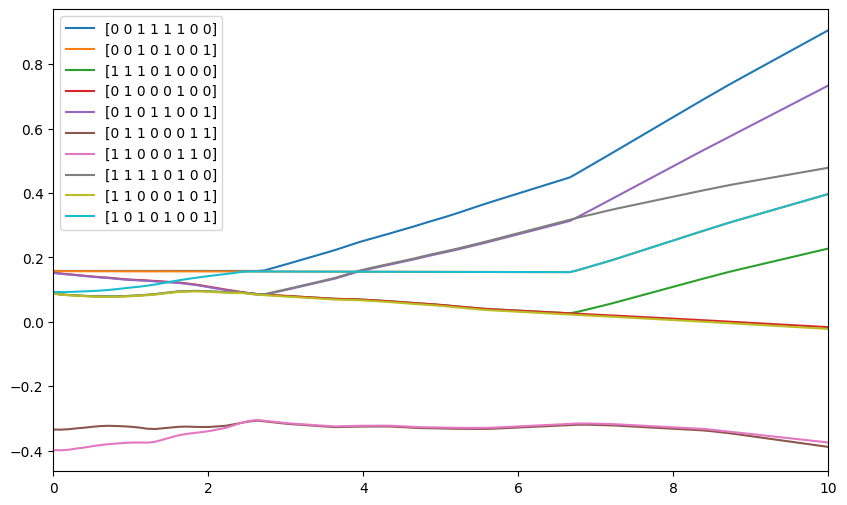

In [5]:
import matplotlib.pyplot as plt

genome_length = 8
num_features = 128

key1w, key1b, key2w, key2b, key3w, key3b = jax.random.split(jax.random.PRNGKey(0), 6)
bias_init = 5e-1

W1 = jax.random.normal(key1w, (1, num_features)) / jnp.sqrt((1 + num_features)/2)
b1 = jax.random.uniform(key1b, (num_features,), minval=-bias_init, maxval=bias_init)
W2 = jax.random.normal(key2w, (num_features, genome_length)) / jnp.sqrt((num_features + genome_length) / 2)
b2 = jax.random.uniform(key2b, (genome_length,), minval=-bias_init, maxval=bias_init)
W3 = jax.random.normal(key3w, (genome_length, 1)) / jnp.sqrt((genome_length + 1) / 2)
b3 = jax.random.uniform(key3b, (1,), minval=-bias_init, maxval=bias_init)
genomes = jax.random.choice(jax.random.PRNGKey(0), generate_all_genomes(genome_length), (min(10, 2**genome_length),), replace=False)


x = jnp.linspace(0, 10, 100).reshape(-1, 1)
plt.figure(figsize=(10, 6))
for g in genomes:
    y = forward_fn(x, W1, b1, W2, b2, W3, b3, g)
    plt.plot(x, y, label=str(g))
plt.xlim(0, 10)
plt.legend()
plt.show()

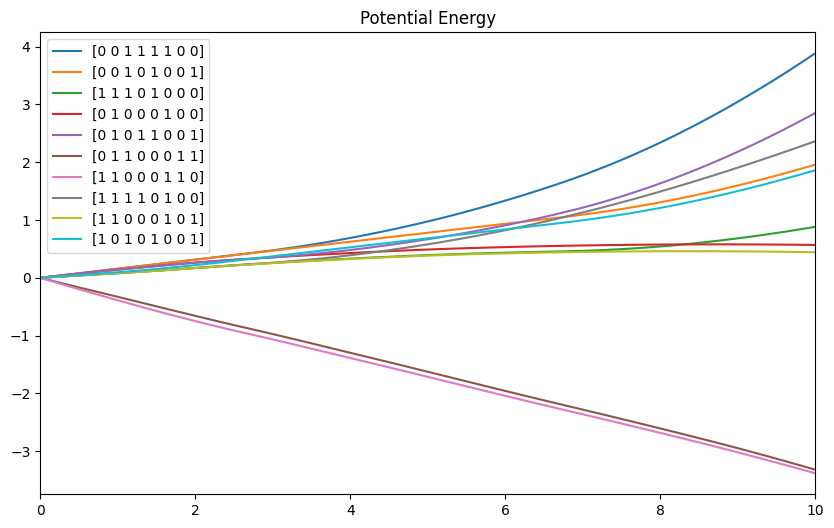

In [4]:
from scipy.integrate import quad

x = jnp.linspace(0, 10, 100)
plt.figure(figsize=(10, 6))
for g in genomes:
    F_values = [quad(lambda t: forward_fn(t, W1, b1, W2, b2, W3, b3, g).item(), 0, x_i, epsabs=1e-2)[0] for x_i in x]
    plt.plot(x, F_values, label=str(g))
plt.xlim(0, 10)
plt.legend()
plt.title("Potential Energy")
plt.show()